# Data Labeling

label tracks with genres

In [1]:
from csv import reader
import numpy as np
from pathlib import Path

## Load Data

In [2]:
data_folder = Path("../data/track_features/").glob('**/*')
files = [x for x in data_folder if x.is_file()]

tracks = []

for f in files:
    with open(f, 'r') as infile:
        rd = reader(infile)
        row1 = next(rd)
        for line in rd:
            tracks.append(line)

In [3]:
print('Total tracks:', len(tracks))

Total tracks: 337127


## Normalize Data

<AxesSubplot:>

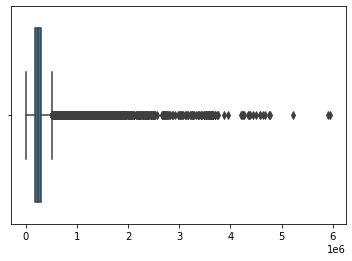

In [4]:
import seaborn as sns

#Boxplot to show outliers
duration_vec = np.array([float(track[13]) for track in tracks])
sns.boxplot(x=duration_vec.T, whis=2)

New total tracks: 326247


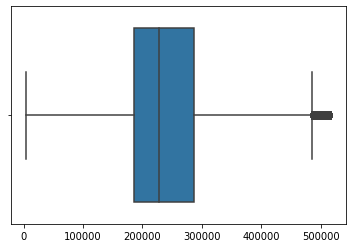

In [5]:
#Removing outliers: songs with duration_ms more than 516000 are removed
tracks = list(filter(lambda x: float(x[13]) < 516000, tracks))

duration_vec = np.array([float(track[13]) for track in tracks])
sns.boxplot(x=duration_vec.T, whis=2)
print('New total tracks:', len(tracks))

<AxesSubplot:>

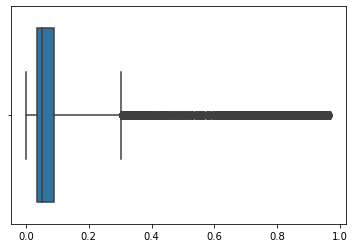

In [6]:
#Boxplot to show outliers
speech_vec = np.array([float(track[7]) for track in tracks])
sns.boxplot(x=speech_vec.T, whis=4)

New total tracks: 311929


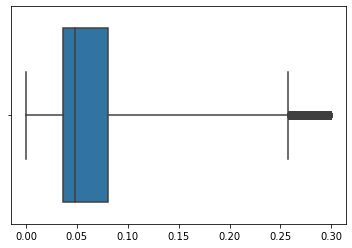

In [7]:
#Removing outliers: songs with speechiness more than 0.2 are removed
tracks = list(filter(lambda x: float(x[7]) < 0.3, tracks))

speech_vec = np.array([float(track[7]) for track in tracks])
sns.boxplot(x=speech_vec.T, whis=4)
print('New total tracks:', len(tracks))

In [8]:
mins = []
maxs = []
for f in range(2, 14):
    column = [float(track[f]) for track in tracks]
    mins.append(min(column))
    maxs.append(max(column))

normalized_tracks = []
for track in tracks:
    normalized = [track[0], track[1]]
    for i in range(2, 14):
        x = float(track[i])
        new_x = (2 * (x - mins[i-2]) / (maxs[i-2] - mins[i-2])) - 1
        normalized.append(new_x)
    normalized_tracks.append(normalized)

## Create Decision Tree

https://www.kaylinpavlik.com/classifying-songs-genres/

In [9]:
EDM = 0
LATIN = 1
POP = 2
RB = 3
RAP = 4
ROCK = 5

#Identify genre based on track features
def getGenre(track):
    speechiness = float(track[7])
    danceability = float(track[2])
    tempo = float(track[12])
    duration_ms = float(track[13])
    if speechiness >= 0.22:
        return RAP
    elif danceability < -0.65:
        return ROCK
    elif tempo >= 0.04:
        return EDM
    elif duration_ms >= 0.36:
        return RB
    elif danceability >= 0.38:
        return LATIN
    else:
        return POP

In [10]:
distr = dict()
new_tracks = []

for i, track in enumerate(normalized_tracks):
    genre = getGenre(track)
    if genre in distr:
        distr[genre] = distr[genre] + 1
    else:
        distr[genre] = 1
    new_tracks.append(tracks[i] + [genre])
    

In [11]:
#Divide data chunks
chunk_indices = []

for i in range(0, len(new_tracks) - len(new_tracks) % 10000, 10000):
    chunk_indices.append((i, i + 10000))

chunk_indices.append((len(new_tracks) - len(new_tracks) % 10000, len(new_tracks)))

In [12]:
import csv

for t in chunk_indices:
    with open('../data/track_features_updated/features.{}-{}.csv'.format(t[0], t[1]), 'w+') as csvFile:
        csvWriter = csv.writer(csvFile, delimiter=',')
        csvWriter.writerow(['track_name', 'artist_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'genre'])
        csvWriter.writerows(new_tracks[t[0]:t[1]])

In [13]:
distr

{0: 105703, 2: 109648, 1: 42566, 4: 21525, 5: 11017, 3: 21470}